This is a notebook on how to use the HSAR sampler from Dong & Harris (2014). 

To replicate their results using the python HSAR code, first we have to set up the data. I'm reading in the data from `test.csv`. Our design matrix has one column, `x`, and no constant. Our response is `y`. We have two weights matrices, `W` for the lower level, and `M` for the upper level. Thus, there are `N = 919` observations pooled into `J=85` units, with `p=1` lower-level parameters (no constant) and `q=1` upper-level parameters (only a constant). 

I'll be setting up the data and the model using `setup_HSAR` in `setup.py`. This function reads in all the data for the dong & harris example and returns a `Gibbs` sampling object.

In [1]:
from setup import setup_HSAR

In [3]:
gibbs = setup_HSAR()

To construct sampler, we call something like this:

```
names = ['betas', 'thetas', 'sigma_e', 
         'sigma_u', 'rho', 'lambda']
samplers = [samp.Betas, samp.Thetas, samp.Sigma_e, 
            samp.Sigma_u, samp.Rho, samp.Lambda]

gibbs = samp.Gibbs(*zip(names, samplers), n=1000)
```

To construct the sampler, you have to pass a set of tuples, `(name, sampler)`, that describe the sampler steps in order. I did it this way because passing a dictionary could rearrange the order of the steps, which is important. I didn't want to use an ordered dict, but that may change. 

Point is, we pass a list of step names and classes/functions that describe what we do in that step. Also, optionally, you can pass something that describes how long the preallocated lists for the trace should be. This shouldn't make a significant performance difference, with `.append` being as fast as it is. 

The most important part of the sampler is its "trace" attribute. The trace records the steps the sampler takes. I'll detail a few methods, but they should also be documented. 

- `trace.Stochastics`: dict with the chains of each sample step
- `trace.Statics`: dict of constants needed in the ampling process
- `trace.Derived`: dict of values that change over the course of a sampling step
- `trace.point(i)`: return Stochastics values at iteration `i`
- `trace.pos`: current step in the trace
- `trace.current()`: return current value of Stochastics at iteration `trace.pos`. 
- `trace.previous()`: return previous value of Stochastics at iteration `trace.pos - 1`. 
- `trace.front()`: returns `trace.current()`, with `None` values replaced by `trace.previous()`. The "most current sampled value".
- `trace.update(str, val)`: update variable `str` with value `val`

From this, we can construct a pretty robust sampling framework. Each step of the gibbs sampler, containined in `gibbs.samplers`, just needs to return a new value when called like `sampler.next()`. It can rely on previous computations through `trace.Derived` and `trace.Statics`, so we can mitigate recomputation, and avoid costly global variable lookups. In addition, the most recent stochastics are grabbed from  `trace.front()`, so that you can compute the typical $p(x_t | y_{t-1})$ values for some sampler $\mathcal{G}(x,y)$

For this problem, it's sufficient to move the sampling procedure forward using the `gibbs.sample()` method, which takes either a number of whole iterations (`n`) or a number of steps to take (`steps`) over the samplers. 

In [4]:
gibbs.sample(n=1000) #takes 1000 samples by iterating over gibbs.samplers

samplers.py:172: UserWarning: Taking 1000 samples runs past preallocated memory. Allocating...
  warn(msg.format(n))
trace.py:67: UserWarning: Sampling past preallocated space. Extending
  warn("Sampling past preallocated space. Extending")


Sampling 0:0


When the sampler was constructed in the setup function, we only preallocated 20 iterations. Going over this is not a big deal, since we just set it to extend the trace as needed. 

So, the most recent parameter values are in `gibbs.trace.Stochastics`. So, just to explore, Let's look at some traceplots.

In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

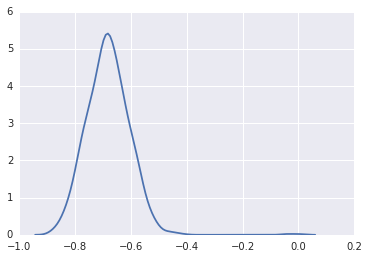

In [15]:
sns.kdeplot(np.array(gibbs.trace.Stochastics['betas']))

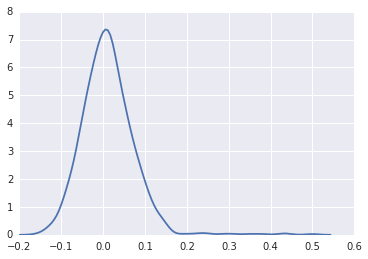

In [16]:
sns.kdeplot(np.array(gibbs.trace.Stochastics['rho']))

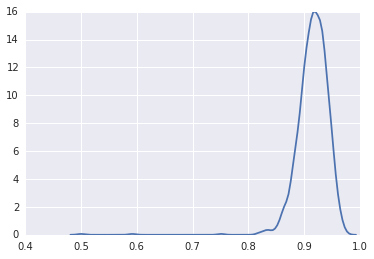

In [17]:
sns.kdeplot(np.array(gibbs.trace.Stochastics['lam']))

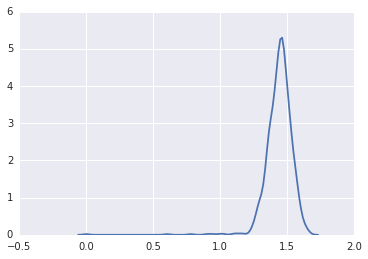

In [23]:
sns.kdeplot(np.array([np.mean(x) for x in gibbs.trace.Stochastics['thetas']]))